## RLlib continued

In [1]:
# HIDDEN
import gym
import numpy as np
import matplotlib.pyplot as plt
from ray import rllib

#### RLlib features

- So far we've seen training, evaluation, and "prediction" with RLlib.
- Next we'll explore a few more features.

#### Configuring the trainer

Earlier, we saw configs like this:

In [3]:
trainer_config = {
    "framework"             : "torch",
    "create_env_on_driver"  : True,
    "seed"                  : 0,
    "model"                 : {"fcnet_hiddens" : [32, 32]},
    "env_config"            : {"is_slippery" : False}
}

- `config={"framework" : "torch"}`: RLlib works with tensorflow (`"tf"` or `"tf2"`) and pytorch (`"torch"`)
- `"create_env_on_driver" : True`: This relates to Ray, and we will touch on it briefly, but not much in this course
-  `"seed" : 0`: This is used for reproducibility of the teaching materials, and is not normally needed
- `"model" : {"fcnet_hiddens" : [32, 32]}`: this tells RLlib to use a smaller-than-default neural network architecture, which helps this slide deck compile/run faster
- `"env_config" : {"is_slippery" : False}`: this selects the non-slippery Frozen Lake
  - All environment hyperparameters go in this sub-dictionary
  
Notes:

We'll discuss tuning in Module 5.

#### Configuring the trainer

We can see the full config, but it's way too long to read!

In [4]:
trainer = rllib.agents.ppo.PPOTrainer(env="FrozenLake-v1", 
                                      config=trainer_config)

In [9]:
len(trainer.config)

105

In [8]:
trainer.config

{'num_workers': 2,
 'num_envs_per_worker': 1,
 'create_env_on_driver': True,
 'rollout_fragment_length': 200,
 'batch_mode': 'truncate_episodes',
 'gamma': 0.99,
 'lr': 5e-05,
 'train_batch_size': 4000,
 'model': {'_use_default_native_models': False,
  '_disable_preprocessor_api': False,
  '_disable_action_flattening': False,
  'fcnet_hiddens': [32, 32],
  'fcnet_activation': 'tanh',
  'conv_filters': None,
  'conv_activation': 'relu',
  'post_fcnet_hiddens': [],
  'post_fcnet_activation': 'relu',
  'free_log_std': False,
  'no_final_linear': False,
  'vf_share_layers': False,
  'use_lstm': False,
  'max_seq_len': 20,
  'lstm_cell_size': 256,
  'lstm_use_prev_action': False,
  'lstm_use_prev_reward': False,
  '_time_major': False,
  'use_attention': False,
  'attention_num_transformer_units': 1,
  'attention_dim': 64,
  'attention_num_heads': 1,
  'attention_head_dim': 32,
  'attention_memory_inference': 50,
  'attention_memory_training': 50,
  'attention_position_wise_mlp_dim': 32,
  

#### Saving models

- We may want to save trained agents for future use.
- This is also called _checkpointing_, especially when done during a training loop.
- In RLlib, this can be done simply with:

```python
trainer.save()
```

It can then be later restored with

```python
trainer.restore(path_to_checkpoint)
```

Just make sure you create the trainer with the same environment and parameters when restoring from a checkpoint.

#### Restoring models

Let's restore a trainer:

In [5]:
trainer.restore("models/FrozenLakeSlippery3232/checkpoint-31")

2022-07-24 09:04:19,130	INFO trainable.py:495 -- Restored on 127.0.0.1 from checkpoint: models/FrozenLakeSlippery3232/checkpoint-31
2022-07-24 09:04:19,132	INFO trainable.py:503 -- Current state after restoring: {'_iteration': 31, '_timesteps_total': 124000, '_time_total': 65.40984463691711, '_episodes_total': 17450}


Notes:

Apparently, it was trained for 30 iterations, 124k time steps, 1 minute, 17k episodes.

#### Viewing stochastic policies

- Some RL algorithms, including PPO, learn stochastic policies.
- We may wish to look at these action probabilities.
- The code can be viewed on GitHub, but is hidden here:

In [6]:
from utils import query_policy

In [7]:
env = gym.make("FrozenLake-v1")

We'll use the trainer we just restored:

In [9]:
query_policy(trainer, env, obs=0)

array([0.36128262, 0.30411848, 0.29477558, 0.03982319], dtype=float32)

Arena:

```
SFFF
FHFH
FFFH
HFFG
```

Actions: left (0), down (1), right (2), up (3).

Notes:
    
What we see here are the action probabilities. From the top-left, the agent considers moving left down or right, but not up. It's not entirely clear why left is preferred to up.

In module 5 we'll see an RL algorithm that acts deterministically.

#### Viewing stochastic policies

Let's view all the probabilities:

In [11]:
# HIDDEN
import pandas as pd

In [26]:
action_probs = {obs : query_policy(trainer, env, obs) for obs in range(16)}
pd.DataFrame(action_probs, index=["left", "down", "right", "up"]).T

,left,down,right,up
0,0.361283,0.304118,0.294776,0.039823
1,0.105703,0.295750,0.179304,0.419243
2,0.878681,0.029604,0.040693,0.051021
3,0.436856,0.262808,0.236151,0.064186
4,0.609650,0.186226,0.176718,0.027406
5,0.430741,0.223148,0.239431,0.106680
6,0.021220,0.542077,0.414277,0.022427
7,0.377155,0.222003,0.223822,0.177020
8,0.016745,0.560293,0.378151,0.044812
9,0.007635,0.627997,0.344637,0.019731


#### Viewing stochastic policies

We can also view this as an image:

In [27]:
# HIDDEN
df = pd.DataFrame(action_probs, index=["left", "down", "right", "up"]).T

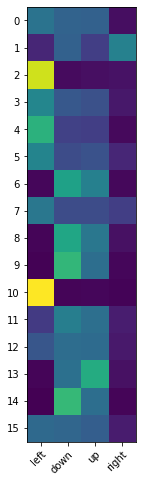

In [29]:
plt.figure(figsize=(4,8))
plt.imshow(df.values);
plt.xticks(np.arange(4), labels=["left", "down", "up", "right"]);
plt.yticks(np.arange(16), labels=np.arange(16));
plt.setp(plt.gca().get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor");

#### Acting stochastically

`compute_single_action` will act according to these probabilities:

In [71]:
action_probs[0]

array([0.36128262, 0.30411848, 0.29477558, 0.03982319], dtype=float32)

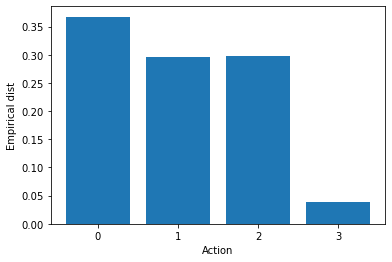

In [86]:
counts = np.bincount([trainer.compute_single_action(0) for _ in range(10_000)])
plt.bar([0,1,2,3], counts/10_000)
plt.xticks([0,1,2,3]);
plt.xlabel("Action");
plt.ylabel("Empirical dist");

#### Acting deterministically

We can also tell the agent to act deterministically with `explore=False`:

In [87]:
trainer.compute_single_action(0, explore=False)

0

In [92]:
print([trainer.compute_single_action(0, explore=False) for _ in range(100)])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


Notes:

During training, exploration is a fundamental concept in RL. We will discuss it in Module 4!

#### Let's apply what we learned!

## RLlib trainer methods
<!-- multiple choice -->

exercise: draw the max prob of the plicy as a measure of sureness

## Visualizing the policy
<!-- coding exercise -->

In the slides we looked at the probability of

could revisit previs Ex but look at probabilities this time